In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

card_df=pd.read_csv("./creditcard.csv")
card_df.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


In [2]:
from sklearn.model_selection import train_test_split

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    df_copy.drop('Time', axis=1, inplace=True)
    return df_copy


In [3]:
def get_train_test_dataset(df=None):
    df_copy=get_preprocessed_df(df)
    X_features=df_copy.iloc[:,:-1]
    y_target=df_copy.iloc[:,-1]
    X_train, X_test, y_train, y_test=train_test_split(X_features, y_target, test_size=0.3, random_state=0, stratify=y_target)
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test=get_train_test_dataset(card_df)

In [4]:
##비율에 맞게 해따

In [5]:
from sklearn.metrics import accuracy_score, precision_score , recall_score , confusion_matrix, f1_score, roc_auc_score

def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix( y_test, pred)
    accuracy = accuracy_score(y_test , pred)
    precision = precision_score(y_test , pred)
    recall = recall_score(y_test , pred)
    f1 = f1_score(y_test,pred)
    # ROC-AUC 추가 
    roc_auc = roc_auc_score(y_test, pred_proba)
    print('오차 행렬')
    print(confusion)
    # ROC-AUC print 추가
    print('정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f},\
    F1: {3:.4f}, AUC:{4:.4f}'.format(accuracy, precision, recall, f1, roc_auc))


In [6]:
from sklearn.linear_model import LogisticRegression

lr_clf=LogisticRegression()
lr_clf.fit(X_train, y_train)
lr_pred=lr_clf.predict(X_test)
lr_pred_proba=lr_clf.predict_proba(X_test)[:,-1]

get_clf_eval(y_test, lr_pred, lr_pred_proba)

오차 행렬
[[85282    13]
 [   57    91]]
정확도: 0.9992, 정밀도: 0.8750, 재현율: 0.6149,    F1: 0.7222, AUC:0.9570


In [7]:
def get_model_train_eval(model, ftr_train=None, ftr_test=None, tgt_train=None, tgt_test=None):
    model.fit(ftr_train, tgt_train)
    pred=model.predict(ftr_test)
    pred_proba=model.predict_proba(ftr_test)[:,1]
    get_clf_eval(tgt_test, pred, pred_proba)

In [8]:
from lightgbm import LGBMClassifier

lgbm_clf=LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf,ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9797


<AxesSubplot:xlabel='Amount', ylabel='Density'>

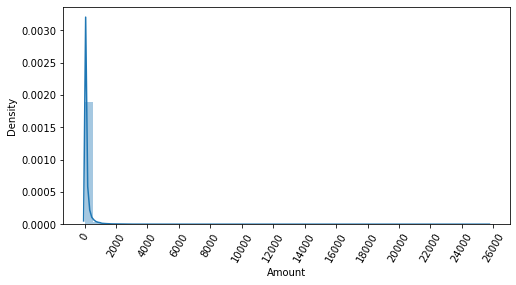

In [9]:
import seaborn as sns
plt.figure(figsize=(8,4))
plt.xticks(range(0,30000,2000), rotation=60)
sns.distplot(card_df['Amount'])

In [10]:
card_df['Amount'].describe()#책이랑 다른데 -> 데이터가 바뀐듯 ㅇㅇ

count    284807.000000
mean         88.349619
std         250.120109
min           0.000000
25%           5.600000
50%          22.000000
75%          77.165000
max       25691.160000
Name: Amount, dtype: float64

In [11]:
from sklearn.preprocessing import StandardScaler

def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=scaler.fit_transform(df_copy['Amount'].values.reshape(-1,1))
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy

In [13]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
lr_clf = LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   58    90]]
정확도: 0.9992, 정밀도: 0.8654, 재현율: 0.6081,    F1: 0.7143, AUC:0.9702
### LightGBM 예측 성능 ###
오차 행렬
[[85289     6]
 [   36   112]]
정확도: 0.9995, 정밀도: 0.9492, 재현율: 0.7568,    F1: 0.8421, AUC:0.9773


In [14]:
#왜곡도 살펴보기(성능 개선 미흡으로 인한)
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    return df_copy 

In [15]:
X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85283    12]
 [   59    89]]
정확도: 0.9992, 정밀도: 0.8812, 재현율: 0.6014,    F1: 0.7149, AUC:0.9727
### LightGBM 예측 성능 ###
오차 행렬
[[85290     5]
 [   35   113]]
정확도: 0.9995, 정밀도: 0.9576, 재현율: 0.7635,    F1: 0.8496, AUC:0.9786


<AxesSubplot:>

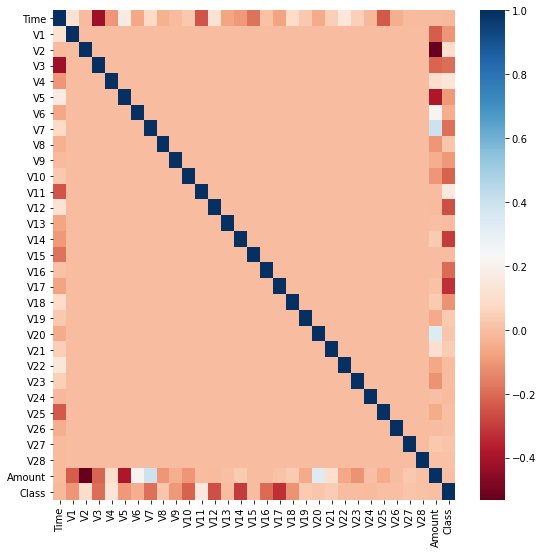

In [16]:
#seaborn
plt.figure(figsize=(9,9))
corr=card_df.corr()
sns.heatmap(corr, cmap="RdBu")
#양의 상관관계가 높을수록 파랑색, 음의 상관관계가 높을수록 진한 빨간색

In [17]:
# 결정 레이블인 class 피쳐와 가장 음의 상관관계가 높은 피쳐는 V14, V17이다. v14만 이상치 제거해볼게

In [21]:
def get_outlier(df=None, column=None, weight=1.5):
    fraud=df[df['Class']==1][column]
    quantile_25=np.percentile(fraud.values, 25)
    quantile_75=np.percentile(fraud.values, 75)
    iqr=quantile_75-quantile_25
    iqr_weight=iqr*weight
    lowest_val=quantile_25-iqr_weight
    highest_val=quantile_75+iqr_weight
    outlier_index=fraud[(fraud<lowest_val)|(fraud>highest_val)].index
    return outlier_index

outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
print("이상치 인덱스(사분위수) ", outlier_index)

이상치 인덱스(사분위수)  Int64Index([8296, 8615, 9035, 9252], dtype='int64')


In [22]:
###이거 다시 작성
def get_preprocessed_df(df=None):
    df_copy=df.copy()
    scaler=StandardScaler()
    amount_n=np.log1p(df_copy['Amount'])
    df_copy.insert(0,'Amount_Scaled', amount_n)
    df_copy.drop(['Time', 'Amount'], axis=1, inplace=True)
    
    outlier_index=get_outlier(df=card_df, column='V14', weight=1.5)
    df_copy.drop(outlier_index, axis=0, inplace=True)
    return df_copy 

X_train, X_test, y_train, y_test = get_train_test_dataset(card_df)

print('### 로지스틱 회귀 예측 성능 ###')
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)

print('### LightGBM 예측 성능 ###')
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


### 로지스틱 회귀 예측 성능 ###
오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743
### LightGBM 예측 성능 ###
오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1: 0.8930, AUC:0.9831


In [25]:
###SMOTE
from imblearn.over_sampling import SMOTE

smote=SMOTE(random_state=0)
X_train_over, y_train_over=smote.fit_sample(X_train, y_train)
print('SMOTE 전용 전 학습용 피쳐/레이블 데이터 세트 : ', X_train_over.shape, y_train.shape)
print('SMOTE 전용 후 학습용 피쳐/레이블 데이터 세트 : ', X_train_over.shape, y_train_over.shape)
print("SMOTE적용 후 레이블값 분포:\n", pd.Series(y_train_over).value_counts())

SMOTE 전용 전 학습용 피쳐/레이블 데이터 세트 :  (398040, 29) (199362,)
SMOTE 전용 후 학습용 피쳐/레이블 데이터 세트 :  (398040, 29) (398040,)
SMOTE적용 후 레이블값 분포:
 1    199020
0    199020
Name: Class, dtype: int64


In [27]:
lr_clf=LogisticRegression()
get_model_train_eval(lr_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85281    14]
 [   48    98]]
정확도: 0.9993, 정밀도: 0.8750, 재현율: 0.6712,    F1: 0.7597, AUC:0.9743


In [28]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.metrics import precision_recall_curve
%matplotlib inline

def precision_recall_curve_plot(y_test , pred_proba_c1):
    # threshold ndarray와 이 threshold에 따른 정밀도, 재현율 ndarray 추출. 
    precisions, recalls, thresholds = precision_recall_curve( y_test, pred_proba_c1)
    
    # X축을 threshold값으로, Y축은 정밀도, 재현율 값으로 각각 Plot 수행. 정밀도는 점선으로 표시
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold 값 X 축의 Scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, 그리고 grid 설정
    plt.xlabel('Threshold value'); plt.ylabel('Precision and Recall value')
    plt.legend(); plt.grid()
    plt.show()
    

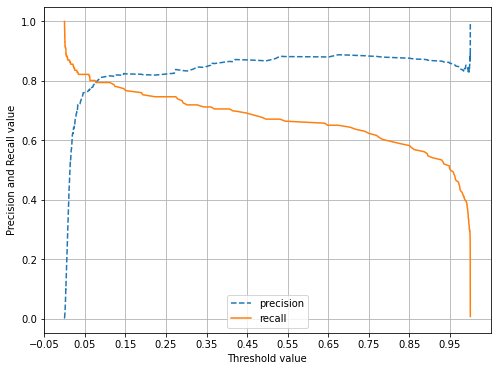

In [29]:
precision_recall_curve_plot(y_test, lr_clf.predict_proba(X_test)[:,1])

In [30]:
lgbm_clf = LGBMClassifier(n_estimators=1000, num_leaves=64, n_jobs=-1, boost_from_average=False)
get_model_train_eval(lgbm_clf, ftr_train=X_train, ftr_test=X_test, tgt_train=y_train, tgt_test=y_test)


오차 행렬
[[85291     4]
 [   25   121]]
정확도: 0.9997, 정밀도: 0.9680, 재현율: 0.8288,    F1: 0.8930, AUC:0.9831
